# Library and Data Check

In [1]:
import cvlib
import cv2
from PIL import Image
import os
import numpy as np
import scipy

2023-08-08 03:03:34.077116: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 03:03:34.121633: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 03:03:34.122160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 03:03:34.896198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


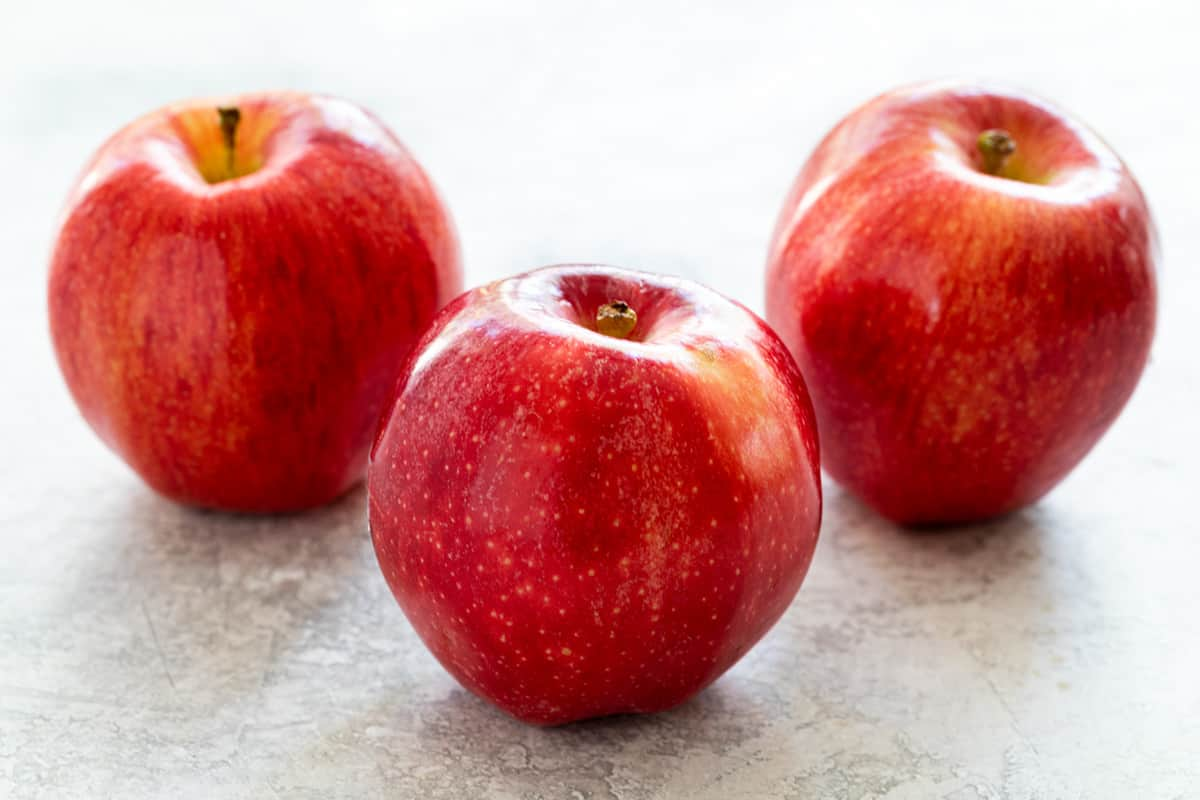

In [2]:
# im_dir = './data/Apple/apple1.jpeg'
im_dir = './data/Apple/apple2.jpg'
img = Image.open(im_dir)
img_arr = np.asarray(img)
img

---

# Code Library

In [3]:
def _cosine_similarity(a, b):
    return np.dot(a,b) / np.linalg.norm(a) *np.linalg.norm(b)

def _quantify_image(image_arr, div=16):
    quantized = image_arr // div * div + div //2
    return quantized


def _find_image_centroid(image_arr, NUM_CLUSTERS = 11):
    arr = image_arr.reshape(scipy.product(image_arr.shape[:2]), image_arr.shape[2]).astype(float) # reshape width and height into 1 dimension
    centroid, dist = scipy.cluster.vq.kmeans(arr, NUM_CLUSTERS)
    vecs, _ = scipy.cluster.vq.vq(arr, centroid)         # assign codes
    counts, _ = scipy.histogram(vecs, len(centroid))    # count occurrences    
    return centroid, counts

In [4]:
class ColorAnalyzer():
    def __init__(self, imageArray, imageMask):
        self.src = imageArray           # Reads in image source
        self.mask = imageMask           # Mask for weighting
        # Empty dictionary container to hold the colour frequencies
        self.color_labels = ['red','green','yellow', 'black']
        self.color_threshold ={'red':[255,10,10],'green':[10,255,10],'yellow':[150,150,0], 'black':[1,1,1]}
        self.color_label = None

    def operate(self, image_count): #rapper to do all the operation
        self.count_colors()
        self.save_image(image_count)

    def count_colors(self):
        quantized_image = _quantify_image(self.src)
        centroid, count =_find_image_centroid(quantized_image)
        similarities = {}
        for cen,cou in zip(centroid,count):
            # temp = {}
            for cl in self.color_labels:
                similarities[cl] = cou * _cosine_similarity(np.array(cen), np.array(self.color_threshold[cl]))
                # print(cl, self.color_threshold[cl], cen, similarities[cl])
        index = sorted(similarities,key=similarities.__getitem__, reverse=True)
        if index[0] == 'black':
            self.color_label=index[1]
        else:
            self.color_label=index[0]
        return index, similarities       

    def save_image(self, count, base_folder='./Image/'):
        if self.color_label is None:
            self.count_colors()
        if base_folder : 
            if not os.path.exists(base_folder):
                os.makedirs(base_folder)
            filename = base_folder             
        else: 
            filename = ''
        filename += "{}_{}.jpg".format(self.color_label,count)
        img = Image.fromarray(self.src)
        img.save(filename)
        return 

In [5]:
class ImageCounter():
    def __init__(self, filename):
        self.labels = ['apple']
        self.filename = filename
        self.image_array = np.asarray(Image.open(filename))
        # self.image_array = np.asarray(Image.open(filename).resize((512,512),2))
        self.cropped_image = []
        self.bboxes = []
        self.count = -1
        self.cropped_masked_image = []
        self.color_analyzer = []

    def count_object(self):
        box, label, count = self._detect_object()
        self.count = 0
        for b, l, c in zip(box, label, count):
            if l in self.labels and c > 0.5:
                self.count += 1
                self.bboxes.append(b)
        if self.count > 0:
            self.crop_image()
            return self.count
        else: 
            return False

    def _detect_object(self):
        # We are using the yolov3 as the base detectron
        box, label, count = cvlib.detect_common_objects(self.image_array,model='yolov3') 
        return box, label, count

    def crop_image(self):
        self.cropped_image = []
        for box in self.bboxes:
            cropped_image = self.image_array[box[1]:box[3],box[0]:box[2]] #crop the image based on bounding boxes
            self.cropped_image.append(cropped_image)
            self.cropped_masked_image.append(self._circular_crop(cropped_image)) #crop the image based on the circular mask
        return self.cropped_image, self.cropped_masked_image

    def _circular_crop(self, image):
        # as apple is very likely circular we will crop it to be circle
        image = image.copy()
        r = int(min(image.shape[:2])/2) # radius
        if r == 0:
            raise Exception('ERROR zRadius 0')
        mask = np.full((image.shape[0], image.shape[1]), 0, dtype=np.uint8) # create a mask
        mask = cv2.circle(mask.copy() ,(r,r), r, (255,255,255),-1)# create circle mask, center, radius, fill color, size of the border
        fg = cv2.bitwise_or(image, image, mask=mask) # get only the inside pixels
        return fg, mask

    def create_color_files(self):
        temp_ca = None
        for idx, (cmi_image,cmi_mask) in enumerate(self.cropped_masked_image):
            temp_ca = ColorAnalyzer(cmi_image, cmi_mask)
            temp_ca.operate(idx+1)
            self.color_analyzer.append(temp_ca)
        return temp_ca

---
# Main Program

## The flow
To use the program initialize the object from class `ImageCounter` with the image file as its parameter. It will automatically call the detection of object using opencv-based library to detect object (using Yolov3 as its backbone). 

The

In [6]:
ic = ImageCounter(im_dir)
object_found = ic.count_object()
print('found {} boxes with coordinate: {}'.format(object_found, ic.bboxes))

found 3 boxes with coordinate: [[762, 79, 1162, 523], [37, 85, 477, 514], [350, 279, 833, 724]]


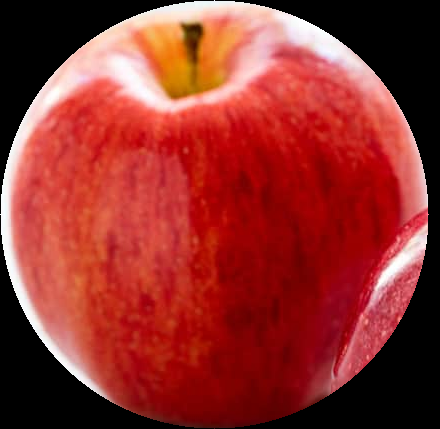

In [7]:
idx = 1
test_img = ic.cropped_masked_image[idx][0]
Image.fromarray(ic.cropped_masked_image[idx][0])

# ---
Classification of the object will be done using the `ColorAnalyzer` class, which already implemented as a part of the `ImageCounter` class in the variable `color_analyzer`. To trigger the process simply initialize the `create_color_files()` function after you create the `ImageCounter` class and run the count object (like the `count.ipynb` notebook). 

The way the method work is by

The result of the methodology will be shown under the folder `Image``.

In [8]:
ic.create_color_files()

/tmp/ipykernel_1405099/813476283.py:10: DeprecationWarning: scipy.product is deprecated and will be removed in SciPy 2.0.0, use numpy.product instead
  arr = image_arr.reshape(scipy.product(image_arr.shape[:2]), image_arr.shape[2]).astype(float) # reshape width and height into 1 dimension
/tmp/ipykernel_1405099/813476283.py:10: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  arr = image_arr.reshape(scipy.product(image_arr.shape[:2]), image_arr.shape[2]).astype(float) # reshape width and height into 1 dimension
/tmp/ipykernel_1405099/813476283.py:13: DeprecationWarning: scipy.histogram is deprecated and will be removed in SciPy 2.0.0, use numpy.histogram instead
  counts, _ = scipy.histogram(vecs, len(centroid))    # count occurrences


# Other Solution

Also another think I want to mention, I also explore the possibilities of approaching the problem using different task framework of framing it as `object counting` problem. After looking at top papers with available code for the problem I found 2 workable solution which is the following paper called `SAFEcount` [(Github link)](https://github.com/zhiyuanyou/SAFECount/tree/main) and called `CounTR` [(Github link)](https://github.com/Verg-Avesta/CounTR/tree/main) ranking in the top 5 performer to solve the task. At first I was working with the `SAFEcount` project and try to tweak it a lot, but since it looks like there is a lot of bug to implement (especially with python  3.11), after spending about a day I decided to move on and work with the other paper. For the `CounTR` project I have tweak with it to some level to make the code works, but sadly with the time frame given I am unable to finish the whole pipeline. I have uploaded my current exploration in a different repository [here](https://github.com/Auberg/CounTR-Experiment). Feel free to take a look at the exploration I have done in the `demo.ipynb` file.